Bibliotecas importadas.
Microdados carregado. Colunas: ['UF', 'Docentes_Graduacao', 'Docentes_Especializacao', 'Docentes_Mestrado', 'Docentes_Doutorado', 'Docentes_Idade_30_34', 'Docentes_Idade_35_39', 'Docentes_Idade_40_44', 'Docentes_Idade_45_49', 'Docentes_Idade_50_54', 'Docentes_Idade_55_59', 'Docentes_Idade_60_mais']
Arquivos CSV carregados com sucesso.
Colunas Survey (exemplo): ["('P1_l ', 'Nivel de Ensino')", "('P0', 'id')", "('P1_m ', 'Área de Formação')", "('P2_h ', 'Faixa salarial')", "('P2_i ', 'Quanto tempo de experiência na área de dados você tem?')"]...

--- Pré-processamento e Engenharia de Variáveis ---
Nomes das colunas do Survey limpos.

Valores únicos em 'P2_h_Faixa_salarial' (amostra): ['de R$ 12.001/mês a R$ 16.000/mês' 'de R$ 6.001/mês a R$ 8.000/mês'
 'de R$ 4.001/mês a R$ 6.000/mês' 'de R$ 8.001/mês a R$ 12.000/mês'
 'de R$ 1.001/mês a R$ 2.000/mês' 'de R$ 3.001/mês a R$ 4.000/mês'
 'de R$ 2.001/mês a R$ 3.000/mês' 'Menos de R$ 1.000/mês'
 'de R$ 101/mês a R$ 2.

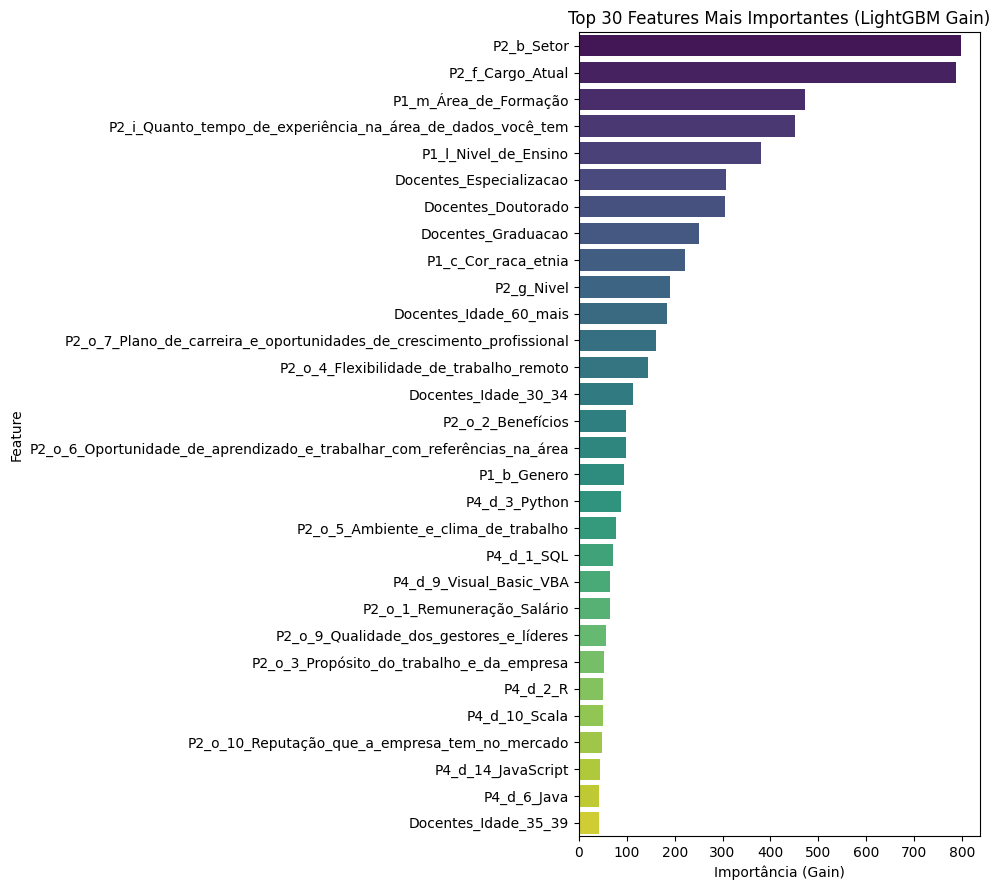


--- 9.2: Gráfico de Previsão vs Real ---


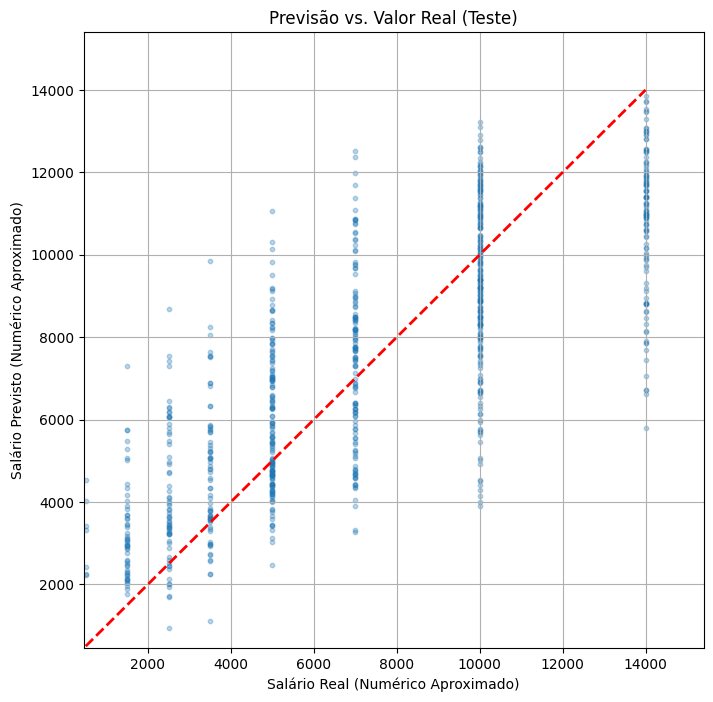


--- 9.3: Visualização da Primeira Árvore de Decisão (lgb.plot_tree) ---


<Figure size 2000x1500 with 0 Axes>

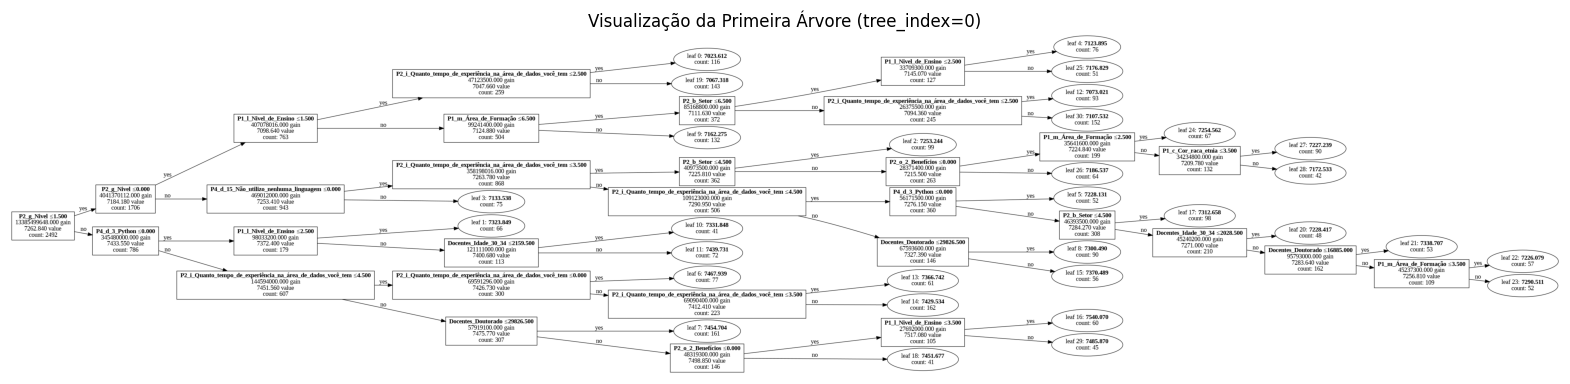

Nota: Esta é apenas UMA das árvores que compõem o modelo GBM.

--- 9.4: Visualização da Primeira Árvore de Decisão (graphviz) ---
Erro ao gerar grafo com graphviz: lightgbm.plotting._to_graphviz() got multiple values for keyword argument 'feature_names'
Verifique se a biblioteca graphviz e seu backend C estão instalados corretamente.
No Kaggle/Colab, isso geralmente funciona. Em ambiente local, pode precisar de instalação adicional (e.g., 'apt-get install graphviz').

--- Fim da Análise ---


In [1]:
# -----------------------------------------
# Passo 0: Instalar Bibliotecas (LightGBM e Graphviz)
# -----------------------------------------
!pip install lightgbm graphviz -q # Adicionado graphviz

# -----------------------------------------
# Passo 1: Importar Bibliotecas
# -----------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz # Importar graphviz
import warnings

warnings.filterwarnings('ignore')

print("Bibliotecas importadas.")
# -----------------------------------------
# Passo 2: Carregar os Dados
# -----------------------------------------
# Ajuste os caminhos se os arquivos estiverem em um diretório diferente no Kaggle
microdados_path = '/kaggle/input/dataset-models-cleaned/microdados_agrupados_por_uf (1)(2).csv' # [1]
survey_path = '/kaggle/input/dataset-models-cleaned/State_of_data_BR_2023_cleaned_v2.csv' # [2]

try:
    df_microdados = pd.read_csv(microdados_path, encoding='utf-8-sig', skipinitialspace=True)
    print(f"Microdados carregado. Colunas: {df_microdados.columns.tolist()}")

    try:
        df_survey = pd.read_csv(survey_path, encoding='utf-8-sig', skipinitialspace=True)
    except UnicodeDecodeError:
        print("Falha ao ler survey com utf-8-sig, tentando latin-1...")
        df_survey = pd.read_csv(survey_path, encoding='latin-1', skipinitialspace=True)

    print("Arquivos CSV carregados com sucesso.")
    print(f"Colunas Survey (exemplo): {df_survey.columns.tolist()[:5]}...")


except FileNotFoundError:
    print(f"Erro: Um ou ambos os arquivos não foram encontrados. Verifique os caminhos:")
    print(f"- {microdados_path}")
    print(f"- {survey_path}")
    raise
except Exception as e:
    print(f"Erro ao carregar CSVs: {e}")
    raise

# -----------------------------------------
# Passo 3: Limpeza e Engenharia de Variáveis (df_survey)
# -----------------------------------------
print("\n--- Pré-processamento e Engenharia de Variáveis ---")

# 3.1 Limpar nomes das colunas do Survey
def clean_col_name(col_name):
    if not isinstance(col_name, str): return str(col_name)
    name = col_name.replace("('", "").replace("')", "").replace("', '", "_").replace('"', '')
    if name.startswith('ï»¿'): name = name[3:]
    name = name.strip(" ,")
    name = name.replace(' / ', '_').replace('/', '_').replace(' ', '_').replace('?', '').replace('__', '_')
    return name

original_cols_survey = df_survey.columns.tolist()
df_survey.columns = [clean_col_name(col) for col in original_cols_survey]
print("Nomes das colunas do Survey limpos.")

# 3.2 Mapear Variável Alvo (Faixa Salarial)
salary_col_cleaned = 'P2_h_Faixa_salarial'
target_col_numeric = 'Faixa_salarial_num'

if salary_col_cleaned in df_survey.columns:
    print(f"\nValores únicos em '{salary_col_cleaned}' (amostra): {df_survey[salary_col_cleaned].unique()[:10]}")
    faixa_map = {
        'Menos de R$ 1.000/mês': 500, 'de R$ 1.001/mês a R$ 2.000/mês': 1500,
        'de R$ 2.001/mês a R$ 3.000/mês': 2500, 'de R$ 3.001/mês a R$ 4.000/mês': 3500,
        'de R$ 4.001/mês a R$ 6.000/mês': 5000, 'de R$ 6.001/mês a R$ 8.000/mês': 7000,
        'de R$ 8.001/mês a R$ 12.000/mês': 10000, 'de R$ 12.001/mês a R$ 16.000/mês': 14000,
        'de R$ 16.001/mês a R$ 20.000/mês': 18000, 'de R$ 20.001/mês a R$ 25.000/mês': 22500,
        'de R$ 25.001/mês a R$ 30.000/mês': 27500, 'de R$ 30.001/mês a R$ 40.000/mês': 35000,
        'Acima de R$ 40.001/mês': 45000
    }
    df_survey[salary_col_cleaned] = df_survey[salary_col_cleaned].str.replace('de R$ 101/mês a R$ 2.000/mês', 'de R$ 1.001/mês a R$ 2.000/mês', regex=False)
    df_survey[target_col_numeric] = df_survey[salary_col_cleaned].str.strip().map(faixa_map)
    mapped_count = df_survey[target_col_numeric].notna().sum()
    total_count = len(df_survey)
    print(f"Mapeamento de '{salary_col_cleaned}' concluído. {mapped_count}/{total_count} mapeados.")
    if mapped_count < total_count * 0.95:
         print(f"AVISO: {total_count - mapped_count} valores de salário não mapeados.")
         print("Valores não mapeados (amostra):")
         print(df_survey[df_survey[target_col_numeric].isna()][salary_col_cleaned].str.strip().unique()[:10])

    df_survey.dropna(subset=[target_col_numeric], inplace=True)
    print(f"Linhas com target numérico nulo removidas. Shape atual: {df_survey.shape}")
else:
    print(f"ERRO CRÍTICO: Coluna de salário '{salary_col_cleaned}' não encontrada.")
    raise KeyError(f"Coluna '{salary_col_cleaned}' não encontrada.")

# 3.3 Selecionar Colunas de Features e Definir Nomes de Colunas de UF
original_feature_list = [
    "P1_l_Nivel_de_Ensino", "P0_id", "P1_m_Área_de_Formação", "P2_h_Faixa_salarial",
    "P2_i_Quanto_tempo_de_experiência_na_área_de_dados_você_tem", "P2_g_Nivel",
    "P4_d_Quais_das_linguagens_listadas_abaixo_você_utiliza_no_trabalho",
    "P4_d_1_SQL", "P4_d_2_R", "P4_d_3_Python", "P4_d_4_C_C++_C#", "P4_d_5_.NET",
    "P4_d_6_Java", "P4_d_7_Julia", "P4_d_8_SAS_Stata", "P4_d_9_Visual_Basic_VBA",
    "P4_d_10_Scala", "P4_d_11_Matlab", "P4_d_12_Rust", "P4_d_13_PHP", "P4_d_14_JavaScript",
    "P4_d_15_Não_utilizo_nenhuma_linguagem", "P1_b_Genero", "P1_c_Cor_raca_etnia",
    "P2_b_Setor", "P1_i_1_uf_onde_mora",
    "P2_f_Cargo_Atual",
    "P4_e_Entre_as_linguagens_listadas_abaixo_qual_é_a_que_você_mais_utiliza_no_trabalho",
    "P2_o_Quais_os_principais_critérios_que_você_leva_em_consideração_no_momento_de_decidir_onde_trabalhar",
    "P2_o_1_Remuneração_Salário", "P2_o_2_Benefícios", "P2_o_3_Propósito_do_trabalho_e_da_empresa",
    "P2_o_4_Flexibilidade_de_trabalho_remoto", "P2_o_5_Ambiente_e_clima_de_trabalho",
    "P2_o_6_Oportunidade_de_aprendizado_e_trabalhar_com_referências_na_área",
    "P2_o_7_Plano_de_carreira_e_oportunidades_de_crescimento_profissional",
    "P2_o_8_Maturidade_da_empresa_em_termos_de_tecnologia_e_dados",
    "P2_o_9_Qualidade_dos_gestores_e_líderes", "P2_o_10_Reputação_que_a_empresa_tem_no_mercado"
]
selected_columns_survey = [col for col in original_feature_list if col in df_survey.columns]
uf_col_survey_cleaned = 'P1_i_1_uf_onde_mora'
uf_col_survey_exists = uf_col_survey_cleaned in df_survey.columns
if not uf_col_survey_exists: print(f"AVISO: Coluna UF limpa '{uf_col_survey_cleaned}' não encontrada no df_survey.")
else: print(f"Coluna UF do Survey encontrada: '{uf_col_survey_cleaned}'")

# -----------------------------------------
# Passo 4: Integrar Microdados
# -----------------------------------------
print("\n--- Integrando Microdados ---")
df_microdados.columns = [clean_col_name(col) for col in df_microdados.columns]
uf_col_micro = 'UF'
uf_col_micro_exists = uf_col_micro in df_microdados.columns
if not uf_col_micro_exists:
    print(f"ERRO/AVISO: Coluna UF '{uf_col_micro}' não encontrada em df_microdados. Merge impossível.")
    df_merged = df_survey.copy()
    microdados_features_in_merged = []
else:
    print(f"Coluna UF dos Microdados encontrada: '{uf_col_micro}'")
    if uf_col_survey_exists:
        print(f"Tentando merge usando Survey:'{uf_col_survey_cleaned}' e Microdados:'{uf_col_micro}'")
        df_survey[uf_col_survey_cleaned] = df_survey[uf_col_survey_cleaned].astype(str).str.strip()
        df_microdados[uf_col_micro] = df_microdados[uf_col_micro].astype(str).str.strip()
        df_merged = pd.merge(df_survey, df_microdados, left_on=uf_col_survey_cleaned, right_on=uf_col_micro, how='left', suffixes=('', '_micro'))
        microdados_features = [col for col in df_microdados.columns if col != uf_col_micro]
        for col in microdados_features:
             col_in_merged = col
             if col + '_micro' in df_merged.columns: col_in_merged = col + '_micro'
             if col_in_merged in df_merged.columns:
                  if pd.api.types.is_numeric_dtype(df_merged[col_in_merged]): df_merged[col_in_merged] = df_merged[col_in_merged].fillna(0)
                  else: df_merged[col_in_merged] = df_merged[col_in_merged].fillna('Desconhecido')
        print(f"Merge concluído. Shape: {df_merged.shape}")
        microdados_features_in_merged = [col for col in df_merged.columns if col.endswith('_micro') or (col in microdados_features and col != uf_col_micro)]
        print(f"{len(microdados_features_in_merged)} features dos microdados adicionadas.")
    else:
        print("Merge não realizado (coluna UF do Survey não encontrada).")
        df_merged = df_survey.copy()
        microdados_features_in_merged = []

# -----------------------------------------
# Passo 5: Selecionar Features Finais (X) e Target (y) do df_merged
# -----------------------------------------
print("\n--- Preparando X e y Finais ---")
possible_feature_columns = [col for col in selected_columns_survey + microdados_features_in_merged if col in df_merged.columns]
cols_to_drop = [
    'P0_id', salary_col_cleaned,
    'P4_d_Quais_das_linguagens_listadas_abaixo_você_utiliza_no_trabalho',
    'P2_o_Quais_os_principais_critérios_que_você_leva_em_consideração_no_momento_de_decidir_onde_trabalhar',
    uf_col_survey_cleaned if uf_col_survey_exists else None,
    uf_col_micro if uf_col_micro_exists else None
]
cols_to_drop = [col for col in cols_to_drop if col is not None]
final_feature_columns = [col for col in possible_feature_columns if col in df_merged.columns and col not in cols_to_drop]
final_feature_columns = sorted(list(set(final_feature_columns)))
X = df_merged[final_feature_columns].copy()
y = df_merged.loc[X.index, target_col_numeric]
print(f"Selecionado X com {X.shape[1]} features e y com {len(y)} amostras.")

# 5.1 Tratar Ausentes e Codificar em X (Final)
print("Tratando ausentes e codificando X final...")
lang_crit_cols = [col for col in X.columns if col.startswith('P4_d_') or col.startswith('P2_o_')]
for col in lang_crit_cols:
    if pd.api.types.is_numeric_dtype(X[col]):
        if X[col].isnull().any(): X[col] = X[col].fillna(0.0)
    else:
         X[col] = X[col].fillna('Desconhecido')
         if not pd.api.types.is_numeric_dtype(X[col]):
             le = LabelEncoder()
             X[col] = le.fit_transform(X[col].astype(str))
categorical_cols_final = X.select_dtypes(include=['object', 'category']).columns
le_dict_final = {}
for col in categorical_cols_final:
    if col not in lang_crit_cols:
        X[col] = X[col].fillna('Desconhecido')
        if not pd.api.types.is_numeric_dtype(X[col]):
             le = LabelEncoder()
             X[col] = le.fit_transform(X[col].astype(str))
             le_dict_final[col] = le
numeric_cols_final = X.select_dtypes(include=np.number).columns
nan_in_numeric = X[numeric_cols_final].isnull().sum()
cols_with_nan = nan_in_numeric[nan_in_numeric > 0].index.tolist()
if cols_with_nan:
     print(f"Preenchendo NaNs nas colunas numéricas finais {cols_with_nan} com 0.")
     X[cols_with_nan] = X[cols_with_nan].fillna(0)
if X.isnull().sum().sum() > 0:
    print("ERRO: Ainda existem NaNs em X!")
    print(X.isnull().sum()[X.isnull().sum() > 0])
    raise ValueError("NaNs encontrados em X após tratamento final.")
else:
    print("Tratamento final de X concluído. Nenhum NaN.")

# -----------------------------------------
# Passo 6: Dividir em Conjuntos de Treino e Teste
# -----------------------------------------
if len(X) == 0 or len(y) == 0 or len(X) != len(y):
     raise ValueError(f"X ({len(X)}) ou y ({len(y)}) está vazio ou com tamanhos diferentes antes do split.")

# Usar test_size = 0.25 para 75% treino / 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Dados divididos em treino 75% ({X_train.shape[0]}) e teste 25% ({X_test.shape[0]}).")

# -----------------------------------------
# Passo 7: Ajuste de Hiperparâmetros e Treinamento do Modelo GBM
# -----------------------------------------
print("\n--- Treinamento do Modelo LightGBM com GridSearchCV ---")
model = lgb.LGBMRegressor(random_state=42)

# *** CORREÇÃO PRINCIPAL: Reduzir drasticamente a grade de parâmetros ***
# Exemplo de grade MUITO menor para teste rápido
param_grid_small = {
    'num_leaves': [31, 60],           # 2 opções
    'max_depth': [-1, 15],            # 2 opções
    'learning_rate': [0.05, 0.1],     # 2 opções
    'n_estimators': [200, 400],       # 2 opções (número menor de árvores)
    'min_child_samples': [20, 40],    # 2 opções
    # Manter apenas um valor para os outros para acelerar MUITO
    'colsample_bytree': [0.8],        # 1 opção
    'reg_alpha': [0.1],               # 1 opção
    'reg_lambda': [0.1]               # 1 opção
}
# Total de combinações: 2*2*2*2*2*1*1*1 = 32 combinações
# Total de fits com cv=5: 32 * 5 = 160 fits (MUITO mais rápido que 77760!)

# Use a grade reduzida 'param_grid_small'
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid_small, # <--- Usando a grade pequena
                           cv=5,
                           scoring='r2',
                           verbose=1,
                           n_jobs=-1) # Usar todos os cores

print("Iniciando GridSearchCV (com grade REDUZIDA)...")
# Agora o .fit() deve terminar em um tempo muito mais razoável
grid_search.fit(X_train, y_train)
print("GridSearchCV concluído.")

best_model = grid_search.best_estimator_
print(f"\nMelhores parâmetros (grade reduzida): {grid_search.best_params_}")
print(f"Melhor R² CV (grade reduzida): {grid_search.best_score_:.4f}")

# -----------------------------------------
# Passo 8: Avaliar no Teste
# -----------------------------------------
print("\n--- Avaliação no Conjunto de Teste ---")
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"MAE: R$ {mae:.2f}")
print(f"RMSE: R$ {rmse:.2f}")
print(f"R²: {r2:.4f}")
if r2 > 0.57: print(f"SUCESSO: R² ({r2:.4f}) melhorou (comparado a 0.57).")
else: print(f"AVISO: R² ({r2:.4f}) não melhorou ou piorou (comparado a 0.57).")
print("Nota: A melhoria pode ser limitada pela grade de parâmetros reduzida usada.")

# --- NOVO CÓDIGO PARA SALVAR RESULTADOS ---
print("\n--- Salvando Resultados da Execução ---")
try:
    # 1. Salvar Previsões vs Reais em CSV
    resultados_df = pd.DataFrame({'Salario_Real': y_test, 'Salario_Previsto': y_pred})
    # Usar o índice original pode ser útil para rastrear de volta ao dado original
    resultados_df.to_csv('previsoes_salario_teste.csv', index=True, index_label='IndiceOriginal')
    print("Arquivo 'previsoes_salario_teste.csv' salvo com sucesso.")

    # 2. Salvar Métricas em TXT
    with open('metricas_modelo.txt', 'w') as f:
        f.write("=== Métricas de Avaliação no Conjunto de Teste ===\n")
        f.write(f"MAE: R$ {mae:.2f}\n")
        f.write(f"RMSE: R$ {rmse:.2f}\n")
        f.write(f"R²: {r2:.4f}\n\n")
        f.write("=== Melhores Hiperparâmetros Encontrados (Grid Reduzida) ===\n")
        for param, value in grid_search.best_params_.items():
            f.write(f"{param}: {value}\n")
        f.write(f"\nMelhor Score R² na Validação Cruzada: {grid_search.best_score_:.4f}\n")
    print("Arquivo 'metricas_modelo.txt' salvo com sucesso.")

except Exception as e:
    print(f"Erro ao salvar arquivos de resultado: {e}")
# --- FIM DO NOVO CÓDIGO ---
# -----------------------------------------
# Passo 9: Gráficos Simples de Interpretação (Expandido)
# -----------------------------------------
print("\n--- Gerando Gráficos de Interpretação ---")

# 9.1 Gráfico de Importância das Features (Como antes)
print("\n--- 9.1: Gráfico de Importância das Features ---")
try:
    importances = best_model.feature_importances_
    features = X_train.columns
    if len(features) == len(importances):
        feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        top_n = 30
        plt.figure(figsize=(10, max(6, min(top_n, len(feature_importance_df)) * 0.3)))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')
        plt.title(f'Top {min(top_n, len(feature_importance_df))} Features Mais Importantes (LightGBM Gain)')
        plt.xlabel('Importância (Gain)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("AVISO: Não foi possível gerar gráfico de importância (discrepância features/importâncias).")
except Exception as e:
    print(f"Erro ao gerar gráfico de importância: {e}")

# 9.2 Gráfico de Previsão vs Real (Como antes)
print("\n--- 9.2: Gráfico de Previsão vs Real ---")
try:
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.3, s=10)
    min_val = min(y_test.min(), y_pred.min()) if not y_test.empty and not np.isnan(y_pred).all() else 0
    max_val = max(y_test.max(), y_pred.max()) if not y_test.empty and not np.isnan(y_pred).all() else 1
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=2)
    plt.xlabel('Salário Real (Numérico Aproximado)')
    plt.ylabel('Salário Previsto (Numérico Aproximado)')
    plt.title('Previsão vs. Valor Real (Teste)')
    plt.xlim(left=min_val*0.9, right=max_val*1.1)
    plt.ylim(bottom=min_val*0.9, top=max_val*1.1)
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Erro ao gerar gráfico de previsão vs real: {e}")

# --- NOVO CÓDIGO ---
# 9.3 Visualização da Primeira Árvore de Decisão (Usando lgb.plot_tree)
print("\n--- 9.3: Visualização da Primeira Árvore de Decisão (lgb.plot_tree) ---")
try:
    plt.figure(figsize=(20, 15)) # Ajuste o tamanho conforme necessário
    lgb.plot_tree(best_model,
                  tree_index=0, # Índice da árvore a ser plotada (0 é a primeira)
                  figsize=(20, 15),
                  show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'] # Informações nos nós
                 )
    plt.title("Visualização da Primeira Árvore (tree_index=0)")
    plt.show()
    print("Nota: Esta é apenas UMA das árvores que compõem o modelo GBM.")
except Exception as e:
    print(f"Erro ao gerar lgb.plot_tree: {e}")
    print("Verifique se o matplotlib está funcionando corretamente.")

# 9.4 Visualização da Primeira Árvore de Decisão (Usando graphviz)
print("\n--- 9.4: Visualização da Primeira Árvore de Decisão (graphviz) ---")
try:
    # Criar o grafo DOT a partir do modelo treinado
    graph_data = lgb.create_tree_digraph(best_model,
                                         tree_index=0, # Índice da árvore
                                         show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
                                         feature_names=X_train.columns.tolist(), # <--- CORREÇÃO: usar plural 'feature_names'
                                         name='Primeira Árvore GBM',
                                         precision=2 # Número de casas decimais
                                        )

    # Renderizar e exibir o grafo
    graph = graphviz.Source(graph_data, format='png')

    # Tentar exibir no notebook
    display(graph)
    print("Nota: Se o grafo não aparecer, pode ser necessário instalar o backend do Graphviz no sistema.")
    print("Nota: Esta é apenas UMA das árvores que compõem o modelo GBM.")

except ImportError:
     print("Erro: A biblioteca 'graphviz' não está instalada ou não foi encontrada.")
     print("Execute: !pip install graphviz")
except Exception as e:
    print(f"Erro ao gerar grafo com graphviz: {e}")
    # Manter as mensagens de erro originais
    print("Verifique se a biblioteca graphviz e seu backend C estão instalados corretamente.")
    print("No Kaggle/Colab, isso geralmente funciona. Em ambiente local, pode precisar de instalação adicional (e.g., 'apt-get install graphviz').")


print("\n--- Fim da Análise ---")

